In [159]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [160]:
# Rango HSV para azules
lower_blue = np.array([ 90,  80,  40]) 
upper_blue = np.array([150, 255, 255]) 

(np.float64(-0.5), np.float64(2057.5), np.float64(618.5), np.float64(-0.5))

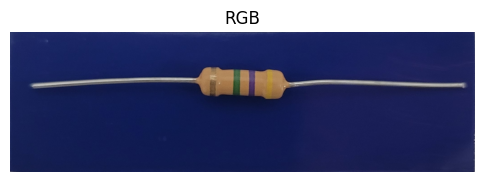

In [161]:
ruta = 'resistencias_out/R7_a_out.jpg'
img_bgr = cv2.imread(ruta)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 4))
plt.imshow(img_rgb)
plt.title('RGB')
plt.axis('off')

(np.float64(-0.5), np.float64(2057.5), np.float64(618.5), np.float64(-0.5))

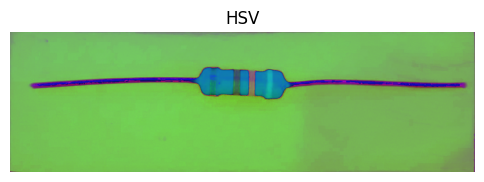

In [162]:
img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
plt.figure(figsize=(6, 4))
plt.imshow(img_hsv)
plt.title('HSV')
plt.axis('off')

(np.float64(-0.5), np.float64(2057.5), np.float64(618.5), np.float64(-0.5))

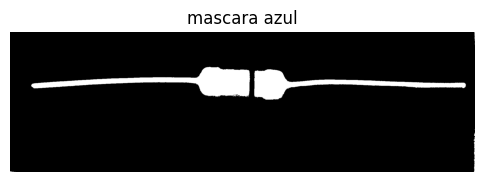

In [163]:
# Create mask to isolate resistor (non-blue regions)
mask = cv2.inRange(img_hsv, lower_blue, upper_blue)
mask = cv2.bitwise_not(mask)  # Invert mask to get resistor
plt.figure(figsize=(6, 4))
plt.imshow(mask, cmap = 'gray')
plt.title('mascara azul')
plt.axis('off')

(np.float64(-0.5), np.float64(2057.5), np.float64(618.5), np.float64(-0.5))

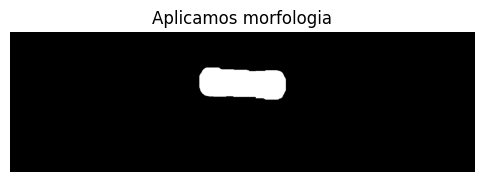

In [164]:
# Aplicamos morfología - Apertura y clausura
kernel_clausura = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
kernel_apertura = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50))
mascara_clausura = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_clausura, iterations=2)
mascara_apertura = cv2.morphologyEx(mascara_clausura, cv2.MORPH_OPEN, kernel_apertura, iterations=1)
plt.figure(figsize=(6, 4))
plt.imshow(mascara_apertura, cmap='gray')
plt.title('Aplicamos morfologia')
plt.axis('off')

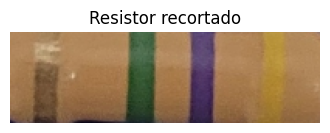

In [165]:
# Find contours to locate the resistor
contornos, _ = cv2.findContours(mascara_apertura, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cont_max = max(contornos, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(cont_max)

padding = 20
x = x + padding
y = y + padding
w = w - 2 * padding
h = h - 2 * padding

resistor_roi = img_bgr[y:y+h, x:x+w]


# Resize ROI to a standard width for consistent band detection
standard_width = 200
aspect_ratio = h / w
standard_height = int(standard_width * aspect_ratio)
resized_roi = cv2.resize(resistor_roi, (standard_width, standard_height))

resized_roi_rgb = cv2.cvtColor(resized_roi, cv2.COLOR_BGR2RGB)

# Mostrar la imagen recortada
plt.figure(figsize=(4, 4))
plt.imshow(resized_roi_rgb)
plt.title('Resistor recortado')
plt.axis('off')
plt.show()


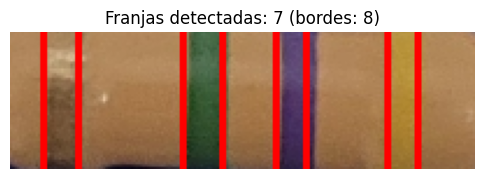

In [166]:
# 1. Convertimos a escala de grises
gray = cv2.cvtColor(resized_roi, cv2.COLOR_BGR2GRAY)

# 2. Calculamos el promedio de intensidad por columna (perfil vertical)
perfil = np.mean(gray, axis=0)

# 3. Derivamos el perfil para detectar bordes verticales (gradientes)
gradiente = np.abs(np.diff(perfil))

# 4. Umbralizamos el gradiente para quedarnos con los cambios más significativos
umbral = 0.09 * np.max(gradiente)
picos = np.where(gradiente > umbral)[0]

# 5. Filtramos bordes muy cercanos (para evitar doble detección en una sola franja)
franjas = []
min_dist = 10  # distancia mínima entre bordes
for pico in picos:
    if len(franjas) == 0 or (pico - franjas[-1] > min_dist):
        franjas.append(pico)

# 6. Dibujamos los bordes detectados sobre la imagen
img_franjas = resized_roi_rgb.copy()
for x in franjas:
    cv2.line(img_franjas, (x, 0), (x, img_franjas.shape[0]), (255, 0, 0), 2)

# 7. Mostrar imagen con las franjas detectadas
plt.figure(figsize=(6, 4))
plt.imshow(img_franjas)
plt.title(f'Franjas detectadas: {len(franjas) - 1} (bordes: {len(franjas)})')
plt.axis('off')
plt.show()

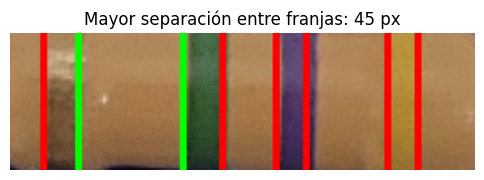

In [167]:
# 8. Agrupar bordes en pares (franjas)
franjas_pares = []
for i in range(0, len(franjas) - 1, 2):
    franjas_pares.append((franjas[i], franjas[i+1]))

# 9. Calcular distancias entre bordes consecutivos
distancias = []
for i in range(1, len(franjas) - 2, 2):
    fin_actual = franjas[i]     # borde derecho de banda i//2
    inicio_siguiente = franjas[i + 1]  # borde izquierdo de banda (i//2 + 1)
    distancia = inicio_siguiente - fin_actual
    distancias.append((i, fin_actual, inicio_siguiente, distancia))  # i = índice del borde izquierdo de la separación

# 10. Buscar la mayor distancia entre bordes consecutivos
mayor_distancia = max(distancias, key=lambda x: x[3])

# 11. Determinar la banda más alejada (la franja dorada)
indice_borde = mayor_distancia[0]  # borde derecho de una banda (franjas[i])
indice_banda_dorada = (indice_borde - 1) // 2  # índice de la banda anterior a la separación

franja_dorada = franjas_pares[indice_banda_dorada]
franjas_colores = [f for i, f in enumerate(franjas_pares) if i != indice_banda_dorada]

# Detección izquierda o derecha (para ordenado visual)
posicion_dorada = 'izquierda' if indice_banda_dorada == 0 else 'derecha' if indice_banda_dorada == len(franjas_pares) - 1 else 'medio'
if posicion_dorada == 'medio':
    print(f"⚠️ La franja dorada no está en un extremo: índice {indice_banda_dorada}. Se considera igualmente válida.")

# 12. Dibujar separación más grande
img_distancia = img_franjas.copy()
cv2.line(img_distancia, (mayor_distancia[1], 0), (mayor_distancia[1], img_franjas.shape[0]), (0, 255, 0), 2)
cv2.line(img_distancia, (mayor_distancia[2], 0), (mayor_distancia[2], img_franjas.shape[0]), (0, 255, 0), 2)

plt.figure(figsize=(6, 4))
plt.imshow(img_distancia)
plt.title(f'Mayor separación entre franjas: {mayor_distancia[3]} px')
plt.axis('off')
plt.show()




Color promedio Dorada: [157.83050847  83.01016949  58.62824859]
Color promedio Banda 1 (más lejana): [193.02477184 104.36245111  42.84093872]
Color promedio Banda 2 (media): [122.99478488  46.06910039  74.14080834]
Color promedio Banda 3 (más cercana): [93.83848455 70.11864407 44.55034895]


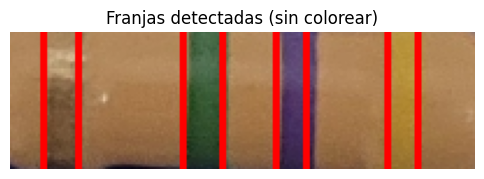

In [ ]:
# Calcular centro de la franja dorada
centro_dorada = (franja_dorada[0] + franja_dorada[1]) // 2

# Calcular distancia de cada franja a la dorada
franjas_con_distancia = []
for franja in franjas_colores:
    centro_franja = (franja[0] + franja[1]) // 2
    distancia = abs(centro_franja - centro_dorada)
    franjas_con_distancia.append((distancia, franja))

# Ordenar de más lejana a más cercana
franjas_ordenadas = sorted(franjas_con_distancia, key=lambda x: -x[0])

# Asignar bandas según cercanía a la dorada
banda1 = franjas_ordenadas[0][1]  # Banda 1 (más lejana a la dorada)
banda2 = franjas_ordenadas[1][1]  # Banda 2 (intermedia)
banda3 = franjas_ordenadas[2][1]  # Banda 3 (más cercana a la dorada)

# Función para obtener el color promedio de una franja
def color_promedio_franja(img, franja):
    x1, x2 = franja
    franja_recorte = img[:, x1:x2]
    color_promedio = franja_recorte.mean(axis=(0, 1))  # BGR si es imagen original de OpenCV
    return color_promedio

# Obtener colores promedio
color_dorada = color_promedio_franja(img_franjas, franja_dorada)
color_banda1 = color_promedio_franja(img_franjas, banda1)
color_banda2 = color_promedio_franja(img_franjas, banda2)
color_banda3 = color_promedio_franja(img_franjas, banda3)

# Mostrar resultados
print("Color promedio Dorada:", color_dorada)
print("Color promedio Banda 1 (más lejana):", color_banda1)
print("Color promedio Banda 2 (media):", color_banda2)
print("Color promedio Banda 3 (más cercana):", color_banda3)

# Visualizar imagen con colores reales (corregido)
plt.figure(figsize=(6, 4))
plt.imshow(img_franjas)  
plt.title('Franjas detectadas')
plt.axis('off')
plt.show()


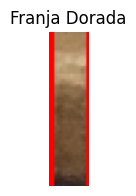

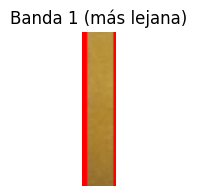

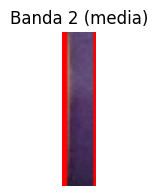

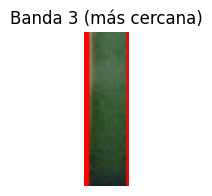

In [169]:
def mostrar_franja_color(img, franja, titulo):
    x1, x2 = franja
    franja_img = img[:, x1:x2]
    plt.figure(figsize=(2, 2))
    plt.imshow(franja_img)
    plt.title(titulo)
    plt.axis('off')
    plt.show()

mostrar_franja_color(img_franjas, franja_dorada, 'Franja Dorada')
mostrar_franja_color(img_franjas, banda1, 'Banda 1 (más lejana)')
mostrar_franja_color(img_franjas, banda2, 'Banda 2 (media)')
mostrar_franja_color(img_franjas, banda3, 'Banda 3 (más cercana)')


In [170]:
# TOMAMOS DIFERENTES PUNTOS DE LAS IMAGENES RECORTADAS PARA OBTENER UN COLOR PROMEDIO
def puntos_promedio_color_rgb(img_rgb, franja, num_puntos=5, margen_vertical=10):
    x1, x2 = franja
    franja_img = img_rgb[:, x1:x2]  # Cortamos la franja completa
    
    alto, ancho, _ = franja_img.shape
    x_centro = ancho // 2

    # Tomamos puntos verticales centrados, separados por margen_vertical
    y_inicio = alto // 2 - margen_vertical * (num_puntos // 2)
    puntos_y = [y_inicio + i * margen_vertical for i in range(num_puntos)]

    colores = []
    for y in puntos_y:
        # Control para que y esté dentro de la imagen
        y = max(0, min(y, alto-1))
        color = franja_img[y, x_centro]
        colores.append(color)

    color_promedio = np.mean(colores, axis=0)
    return color_promedio.astype(int)

# Ejemplo de uso (asumiendo img_franjas es RGB):
color_prom_banda1 = puntos_promedio_color_rgb(img_franjas, banda1)
color_prom_banda2 = puntos_promedio_color_rgb(img_franjas, banda2)
color_prom_banda3 = puntos_promedio_color_rgb(img_franjas, banda3)

print("Color promedio banda1 (RGB):", color_prom_banda1)
print("Color promedio banda2 (RGB):", color_prom_banda2)
print("Color promedio banda3 (RGB):", color_prom_banda3)


Color promedio banda1 (RGB): [173 134  50]
Color promedio banda2 (RGB): [ 79  57 102]
Color promedio banda3 (RGB): [54 85 52]


In [171]:
def detectar_color_rgb(color_prom):
    # Definimos los colores con sus rangos (mín, máximo) por canal RGB
    colores_rangos = {
        'Marron': {
            'min': np.array([62, 13, 2]),   # 92-30, 43-30, 32-30
            'max': np.array([122, 73, 62])  # 92+30, 43+30, 32+30
        },
        'Rojo': {
            'min': np.array([122, 21, 14]),
            'max': np.array([182, 81, 74])
        },
        'Naranja': {
            'min': np.array([149, 71, 16]),
            'max': np.array([209, 131, 76])
        },
        'Amarillo': {
            'min': np.array([150, 120, 20]),  # ajusta si hace falta
            'max': np.array([255, 200, 100])
        },
        'Morado': {
            'min': np.array([50, 30, 70]),
            'max': np.array([130, 90, 150])
        },
        'Verde': {
            'min': np.array([30, 50, 20]),
            'max': np.array([80, 140, 80])
        }
    }

    for color_nombre, rangos in colores_rangos.items():
        if np.all(color_prom >= rangos['min']) and np.all(color_prom <= rangos['max']):
            return color_nombre

    return 'desconocido'

# Ahora aplicamos para tus colores promedio:

print("Banda1:", detectar_color_rgb(color_prom_banda1))  
print("Banda2:", detectar_color_rgb(color_prom_banda2))  
print("Banda3:", detectar_color_rgb(color_prom_banda3))  


Banda1: Amarillo
Banda2: Morado
Banda3: Verde
